# Landuse accessibility from GeoPandas data

Calculate landuse accessibilities from a `geopandas` `GeoDataFrame`.


In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from cityseer.metrics import layers
from cityseer.tools import graphs, io


To start, follow the same approach as shown in the network examples to create the network.


In [2]:
streets_gpd = gpd.read_file("data/madrid_streets/street_network.gpkg")
streets_gpd = streets_gpd.explode(reset_index=True)
G = io.nx_from_generic_geopandas(streets_gpd)
G_dual = graphs.nx_to_dual(G)
nodes_gdf, _edges_gdf, network_structure = io.network_structure_from_nx(G_dual)

100%|██████████| 47155/47155 [00:07<00:00, 6021.55it/s]
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 1.
100%|██████████| 47129/47129 [00:00<00:00, 118489.31it/s]
INFO:cityseer.tools.graphs:Converting graph to dual.
INFO:cityseer.tools.graphs:Preparing dual nodes
100%|██████████| 47129/47129 [00:01<00:00, 36386.93it/s]
INFO:cityseer.tools.graphs:Preparing dual edges (splitting and welding geoms)
100%|██████████| 47129/47129 [01:32<00:00, 508.77it/s]
INFO:cityseer.tools.io:Preparing node and edge arrays from networkX graph.
100%|██████████| 47129/47129 [00:14<00:00, 3159.02it/s]
INFO:cityseer.graph:Edge R-tree built successfully with 104026 items.


Read-in the dataset from the source Geopackage or Shapefile Geopandas.


In [3]:
prems_gpd = gpd.read_file("data/madrid_premises/madrid_premises.gpkg")
prems_gpd.head()

,index,local_id,local_distr_id,local_distr_desc,local_neighb_id,local_neighb_desc,local_neighb_code,local_census_section_id,local_census_section_desc,section_id,section_desc,division_id,division_desc,epigraph_id,epigraph_desc,easting,northing,geometry
0,0,10003324,1,CENTRO,105,UNIVERSIDAD,5,1091,91,I,hospitality,56,food_bev,561001,RESTAURANTE,440181.6,4475586.5,POINT (440181.6 4475586.5)
1,1,10003330,1,CENTRO,105,UNIVERSIDAD,5,1115,115,R,art_rec_entert,90,creat_entert,900003,TEATRO Y ACTIVIDADES ESCENICAS REALIZADAS EN D...,440000.6,4474761.5,POINT (440000.6 4474761.5)
2,2,10003356,1,CENTRO,104,JUSTICIA,4,1074,74,I,hospitality,56,food_bev,561004,BAR RESTAURANTE,440618.6,4474692.5,POINT (440618.6 4474692.5)
3,3,10003364,1,CENTRO,104,JUSTICIA,4,1075,75,G,wholesale_retail_motor,47,retail,472401,COMERCIO AL POR MENOR DE PAN Y PRODUCTOS DE PA...,440666.6,4474909.5,POINT (440666.6 4474909.5)
4,4,10003367,1,CENTRO,106,SOL,6,1119,119,G,wholesale_retail_motor,47,retail,477701,"COMERCIO AL POR MENOR DE JOYAS, RELOJERIA Y BI...",440378.6,4474380.5,POINT (440378.6 4474380.5)


Identify or prepare any columns and land uses of interest, for which you want to compute accessibilities.


In [4]:
prems_gpd.division_desc.unique()

array(['food_bev', 'creat_entert', 'retail', 'services', 'education',
       'accommod', 'Real Estate Activities',
       'Residential Care Activities',
       'Social Services Without Accommodation',
       'Graphic Arts and Reproduction of Recorded Media',
       'Sale and Repair of Motor Vehicles and Motorcycles',
       'Decontamination and Other Waste Management Services',
       'Gambling and Betting Activities', 'sports_rec', 'health',
       'Wholesale Trade and Middlemen, Except for Motor Vehicles and Motorcycles',
       'Telecommunications',
       'Financial Services, Except Insurance and Pension Funds',
       'Associative Activities', 'Veterinary Activities',
       'Auxiliary Services to Financial Services and Insurance',
       'Insurance, Reinsurance, and Pension Funds, Except Compulsory Social Security',
       'Rental Activities',
       'Office Administrative and Other Business Support Activities',
       'Technical Services of Architecture and Engineering; Technica

Once the land use and network data has been prepared, use the [`layers.compute_accessibilities`](https://cityseer.benchmarkurbanism.com/metrics/layers#compute-accessibilities) method to compute accessibilities to land uses. The `landuse_column_label` and the target accessibility keys should correspond to the data in the input GeoDataFrame.


In [10]:
# compute pub accessibility
distances = [100, 200, 400, 800]
nodes_gdf, prems_gpd = layers.compute_accessibilities(
    prems_gpd,
    landuse_column_label="division_desc",
    accessibility_keys=["food_bev", "creat_entert", "retail"],
    nodes_gdf=nodes_gdf,
    network_structure=network_structure,
    distances=distances,
)

INFO:cityseer.metrics.layers:Computing land-use accessibility for: food_bev, creat_entert, retail
INFO:cityseer.metrics.layers:Assigning data to network.
INFO:cityseer.data:Assigning 117358 data entries to network nodes (max_dist: 400).
INFO:cityseer.data:Collected 198409 potential node assignments from data entries.
INFO:cityseer.data:Finished assigning data. 198409 assignments added to 24598 nodes.
INFO:cityseer.graph:Barriers unset and R-tree cleared.
100%|██████████| 47129/47129 [00:17<00:00, 2742.04it/s]
INFO:cityseer.config:Metrics computed for:
INFO:cityseer.config:Distance: 100m, Beta: 0.04, Walking Time: 1.25 minutes.
INFO:cityseer.config:Distance: 200m, Beta: 0.02, Walking Time: 2.5 minutes.
INFO:cityseer.config:Distance: 400m, Beta: 0.01, Walking Time: 5.0 minutes.
INFO:cityseer.config:Distance: 800m, Beta: 0.005, Walking Time: 10.0 minutes.


The output columns are named `cc_{key}_{distance}_{type}`. Where the keys will correspond to the input accessibility keys and the distances will correspond to the input distances. The types will correspond to either non-weighted `nw` or distance weighted `wt` count, or else the distance to the nearest instance of a given landuse.

Standard GeoPandas functionality can be used to explore, visualise, or save the results.


In [6]:
nodes_gdf.columns

Index(['ns_node_idx', 'x', 'y', 'live', 'weight', 'primal_edge',
       'primal_edge_node_a', 'primal_edge_node_b', 'primal_edge_idx',
       'dual_node', 'cc_food_bev_100_nw', 'cc_food_bev_100_wt',
       'cc_food_bev_200_nw', 'cc_food_bev_200_wt', 'cc_food_bev_400_nw',
       'cc_food_bev_400_wt', 'cc_food_bev_800_nw', 'cc_food_bev_800_wt',
       'cc_food_bev_nearest_max_800', 'cc_creat_entert_100_nw',
       'cc_creat_entert_100_wt', 'cc_creat_entert_200_nw',
       'cc_creat_entert_200_wt', 'cc_creat_entert_400_nw',
       'cc_creat_entert_400_wt', 'cc_creat_entert_800_nw',
       'cc_creat_entert_800_wt', 'cc_creat_entert_nearest_max_800',
       'cc_retail_100_nw', 'cc_retail_100_wt', 'cc_retail_200_nw',
       'cc_retail_200_wt', 'cc_retail_400_nw', 'cc_retail_400_wt',
       'cc_retail_800_nw', 'cc_retail_800_wt', 'cc_retail_nearest_max_800'],
      dtype='object')

(np.float64(439000.0),
 np.float64(441500.0),
 np.float64(4473000.0),
 np.float64(4475500.0))

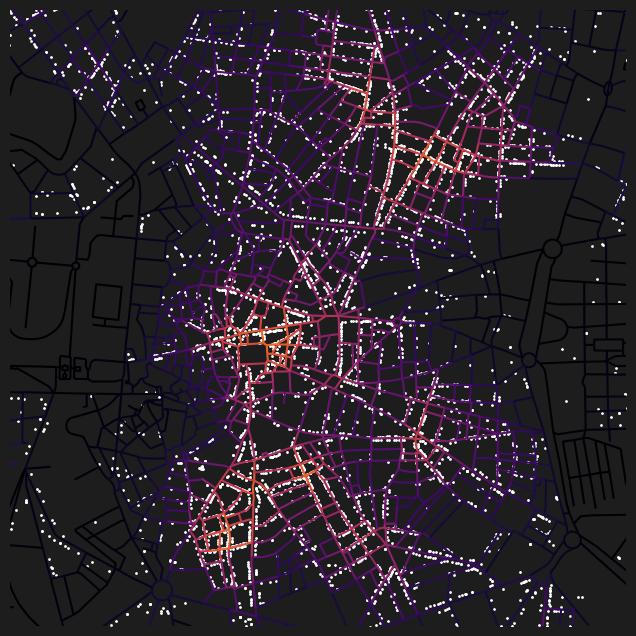

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), facecolor="#1d1d1d")
nodes_gdf.plot(
    column="cc_retail_400_wt",
    cmap="inferno",
    legend=False,
    ax=ax,
)
prems_gpd[prems_gpd["division_desc"] == "retail"].plot(
    markersize=1,
    edgecolor=None,
    color="white",
    legend=False,
    ax=ax,
)
ax.set_xlim(439000, 439000 + 2500)
ax.set_ylim(4473000, 4473000 + 2500)
ax.axis(False)


(np.float64(439000.0),
 np.float64(441500.0),
 np.float64(4473000.0),
 np.float64(4475500.0))

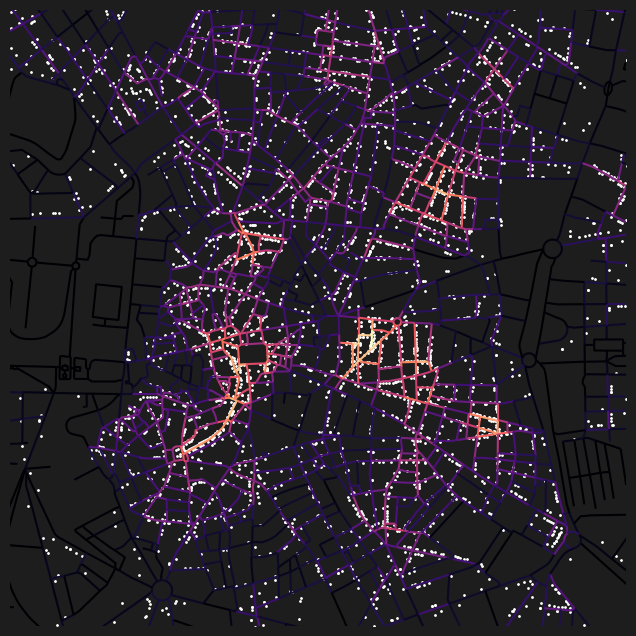

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), facecolor="#1d1d1d")
nodes_gdf.plot(
    column="cc_food_bev_200_wt",
    cmap="magma",
    legend=False,
    ax=ax,
)
prems_gpd[prems_gpd["division_desc"] == "food_bev"].plot(
    markersize=1,
    edgecolor=None,
    color="white",
    legend=False,
    ax=ax,
)
ax.set_xlim(439000, 439000 + 2500)
ax.set_ylim(4473000, 4473000 + 2500)
ax.axis(False)


/var/folders/9_/5x31j5x55819zxycf85n4cp40000gq/T/ipykernel_32096/3453596325.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  nodes_gdf["cc_creat_entert_nearest_max_800"].fillna(800, inplace=True)


(np.float64(439000.0),
 np.float64(441500.0),
 np.float64(4473000.0),
 np.float64(4475500.0))

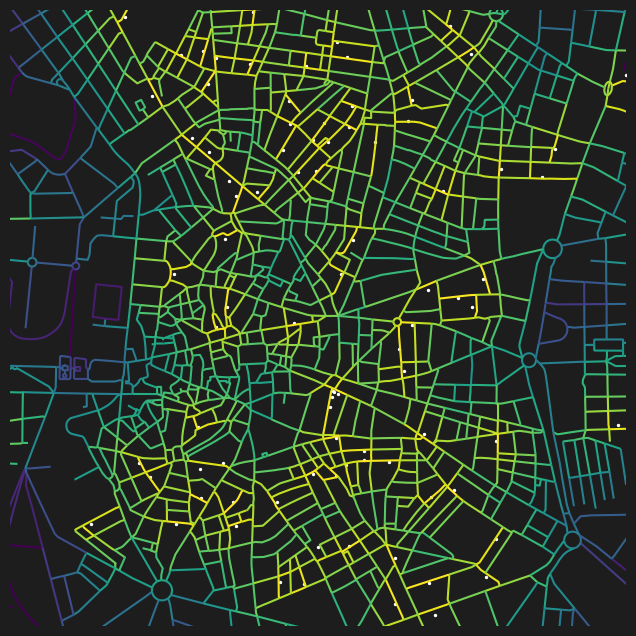

In [9]:
nodes_gdf["cc_creat_entert_nearest_max_800"].fillna(800, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(8, 8), facecolor="#1d1d1d")
nodes_gdf.plot(
    column="cc_creat_entert_nearest_max_800",
    cmap="viridis_r",
    legend=False,
    ax=ax,
)
prems_gpd[prems_gpd["division_desc"] == "creat_entert"].plot(
    markersize=2,
    edgecolor=None,
    color="white",
    legend=False,
    ax=ax,
)
ax.set_xlim(439000, 439000 + 2500)
ax.set_ylim(4473000, 4473000 + 2500)
ax.axis(False)